In [1]:
import jax_galsim as galsim
import galsim as _galsim
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random
import chainconsumer as cc

2024-07-02 08:30:01.695394: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-07-02 08:30:18.040785: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tensorflow_probability as tfp

In [3]:
from numpyro.diagnostics import gelman_rubin, effective_sample_size, autocorrelation

In [4]:
jax.devices()

[cuda(id=0)]

In [5]:
def add_noise(x: np.ndarray, bg: float, n=1, noise_factor=1):
    """Produce `n` independent Gaussian noise realizations of a given image `x`.

    NOTE: This function assumes image is background-subtracted and dominated.
    """
    x = x.reshape(1, *x.shape)
    x = x.repeat(n, axis=0)
    noise = np.random.randn(*x.shape) * np.sqrt(bg) * noise_factor
    return x + noise, noise

In [6]:
# converegence?
def my_gelman_rubin(x):
    # from https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html
    assert x.ndim == 2  # (n_chains, n_samples)
    assert x.shape[0] >= 2
    assert x.shape[1] >= 2

    J = x.shape[0]
    L = x.shape[1]

    chain_mean = x.mean(axis=1)
    grand_mean = chain_mean.mean()

    # between chain variance
    B = (L / (J - 1)) * np.sum((chain_mean - grand_mean) ** 2)

    # within chain variance
    sj_sq = (1 / (L - 1)) * np.sum((x - chain_mean.reshape(-1, 1)) ** 2, axis=1)
    W = (1 / J) * np.sum(sj_sq, axis=0)

    return ((L - 1) / L * W + B / L) / W


# Benchmark galaxy drawing

In [7]:
GSPARAMS = galsim.GSParams(minimum_fft_size=512, maximum_fft_size=512)

@jax.jit
def draw_gal(lf, hlr, x, y, e1, e2):
    gal = galsim.Gaussian(flux=10**lf, half_light_radius=hlr)
    gal = gal.shear(g1=e1, g2=e2)
    pos = galsim.PositionD(x=x, y=y)
    psf = galsim.Gaussian(flux=1., half_light_radius=0.7)
    gal_conv = galsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 offset=pos,
                                 )
    return image.array

In [8]:
%time draw_gal(5, 0.9, 0.0, 0.0, 0.2, 0).block_until_ready()
%timeit draw_gal(5, 0.9, 0.0, 0.0, 0.2, 0).block_until_ready()

NameError: name 'SLEN' is not defined

NameError: name 'SLEN' is not defined

In [ ]:
%%timeit
for ii in range(100):
    draw_gal(4.5+ii/100, 0.9+ii/100*2, 0.0, 0.0, 0.2, 0).block_until_ready()

# Single Galaxy (SNR 20)

In [9]:
PSF_HLR = 0.7
PIXEL_SCALE = 0.2
SLEN = 51
BACKGROUND = 1e4

# galaxy
TRUE_HLR = 0.9
LOG_TRUE_FLUX = 4.55
TRUE_FLUX = 10**LOG_TRUE_FLUX
TRUE_X = 0.
TRUE_Y = 0.

#ellipticity
G1 = 0.2
G2 = 0.0

#params
TRUE_PARAMS = {'lf': LOG_TRUE_FLUX, 'hlr': TRUE_HLR, 'x': TRUE_X, 'y': TRUE_Y, 'e1': G1, 'e2': G2}
TRUE_PARAMS_ARR = {k:jnp.array([v]) for k,v in TRUE_PARAMS.items()}

In [10]:
# get true image
def _draw_gal():
    gal = _galsim.Gaussian(flux=TRUE_FLUX, half_light_radius=TRUE_HLR)
    gal = gal.shear(g1=G1, g2=G2)
    pos = _galsim.PositionD(x=TRUE_X, y=TRUE_Y)
    psf = _galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = _galsim.Convolve([gal, psf])
    gal_conv = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                  offset=pos)
    im = gal_conv.array
    return im

In [11]:
GSPARAMS = galsim.GSParams(minimum_fft_size=512, maximum_fft_size=512)

@jax.jit
@jax.vmap
def draw_gal(lf, hlr, x, y, e1, e2):
    gal = galsim.Gaussian(flux=10**lf, half_light_radius=hlr)
    gal = gal.shear(g1=e1, g2=e2)
    pos = galsim.PositionD(x=x, y=y)
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 offset=pos,
                                 )
    return image.array

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu1/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


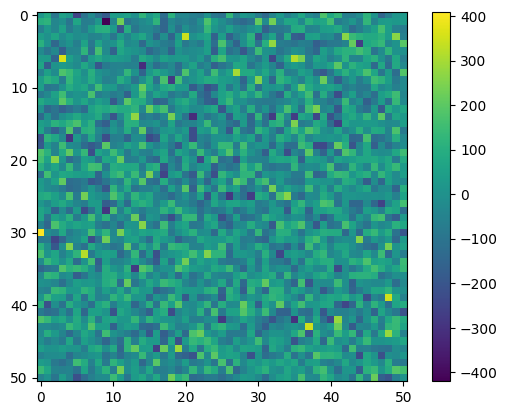

In [12]:
# check error is very small on true thingies
TRUE_IMAGE = _draw_gal()
im, _ = add_noise(TRUE_IMAGE, BACKGROUND)
arr = im[0] - draw_gal(**TRUE_PARAMS_ARR)[0]
plt.imshow(arr)
plt.colorbar()

In [13]:
# SNR
x1 = TRUE_IMAGE
np.sqrt(np.sum( (x1 * x1) / (x1 + BACKGROUND)))

20.27947

In [14]:
def prob_model(data):
    batch_dim, _, _ = data.shape
    with numpyro.plate('b', batch_dim, dim=-1):
        lf = numpyro.sample('lf', dist.Uniform(4,6))
        hlr = numpyro.sample('hlr', dist.Uniform(0.5, 1.5))
        x = numpyro.sample('x', dist.Uniform(-0.5, 0.5))
        y = numpyro.sample('y', dist.Uniform(-0.5, 0.5))
        e1 = numpyro.sample('e1', dist.Uniform(-0.5, 0.5))
        e2 = numpyro.sample('e2', dist.Uniform(-0.5, 0.5))
    im = draw_gal(lf, hlr, x, y, e1, e2)
    numpyro.sample('obs', dist.Normal(im, jnp.sqrt(BACKGROUND)), obs=data)

In [38]:
data, _ = add_noise(TRUE_IMAGE, BACKGROUND, n=1)
nuts_kernel = NUTS(prob_model, max_tree_depth=10)
mcmc = MCMC(nuts_kernel, num_warmup=200, num_samples=10000, num_chains=1)
rng_key = random.PRNGKey(42)
mcmc.run(rng_key, data=data)

sample: 100%|██████████| 10200/10200 [01:15<00:00, 136.00it/s, 7 steps of size 4.86e-01. acc. prob=0.91] 


In [39]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     e1[0]      0.18      0.07      0.18      0.07      0.29   8352.26      1.00
     e2[0]      0.02      0.08      0.02     -0.11      0.15  10140.46      1.00
    hlr[0]      1.02      0.08      1.02      0.88      1.14   7003.43      1.00
     lf[0]      4.58      0.03      4.58      4.53      4.63   7821.88      1.00
      x[0]     -0.04      0.26     -0.05     -0.49      0.34  14032.80      1.00
      y[0]      0.05      0.25      0.06     -0.32      0.48  10557.22      1.00

Number of divergences: 0


In [41]:
e1 = mcmc.get_samples(group_by_chain=True)['e1'][:, :, 0]
e2 = mcmc.get_samples(group_by_chain=True)['e2'][:, :, 0]
e1.shape

(1, 10000)

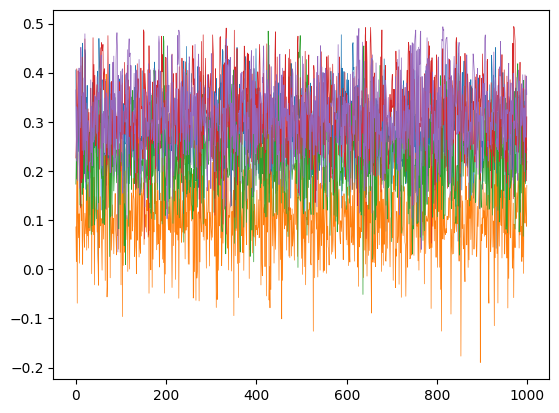

In [22]:
plt.plot(e1[:,0], linewidth=0.5)
plt.plot(e1[:,1], linewidth=0.5)
plt.plot(e1[:,2], linewidth=0.5)
plt.plot(e1[:,3], linewidth=0.5)
plt.plot(e1[:,4], linewidth=0.5)

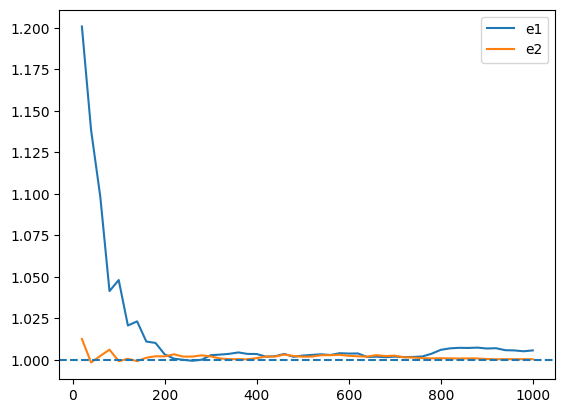

In [35]:
# as a function of chain length
xs = np.arange(20, 1001, 20)
gs1 = [my_gelman_rubin(e1[:, :ii]) for ii in range(20, 1001, 20)]
gs2 = [my_gelman_rubin(e2[:, :ii]) for ii in range(20, 1001, 20)]
plt.plot(xs, gs1, label='e1')
plt.plot(xs, gs2, label='e2')
plt.axhline(1.0, linestyle='--')
plt.legend(loc='best')

In [25]:
print(my_gelman_rubin(e1), gelman_rubin(e1), my_gelman_rubin(e2), gelman_rubin(e2))

0.8908945 0.94387203 0.8731442 0.9344219


In [42]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i


def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

Text(0.5, 1.0, 'e1 autocorrelations')

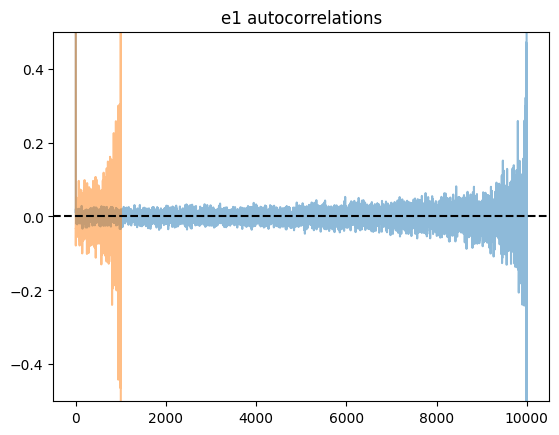

In [55]:
e1_corrs = autocorrelation(e1[0, :])
e1_corrs_1000 = autocorrelation(e1[0, :1000])
plt.plot(e1_corrs, alpha=0.5)
plt.plot(e1_corrs_1000, alpha=0.5)
plt.axhline(0.0, color='k', linestyle='--')
plt.ylim(-0.5, 0.5)
plt.title('e1 autocorrelations')

(-0.5, 0.5)

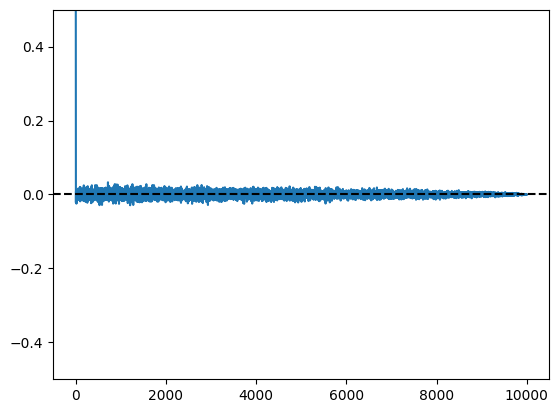

In [47]:
x = np.random.randn(10000)
autocorr_x = autocorr_func_1d(x)
plt.plot(autocorr_x)
plt.axhline(0.0, color='k', linestyle='--')
plt.ylim(-0.5, 0.5)


<ErrorbarContainer object of 3 artists>

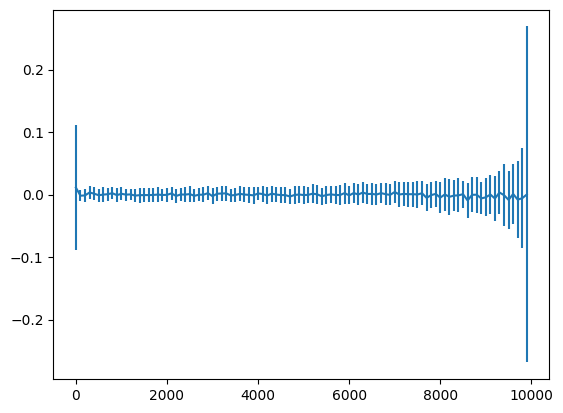

In [45]:
e1_corrs_binned_mean = [] 
e1_corrs_binned_scatter = [] 
for ii in range(0, 10000, 100): 
    e1_corrs_binned_mean.append(np.mean(e1_corrs[ii:ii+100]))
    e1_corrs_binned_scatter.append(np.std(e1_corrs[ii:ii+100]))

plt.errorbar(x =np.arange(0, 10000, 100), y = e1_corrs_binned_mean, yerr=e1_corrs_binned_scatter)
    

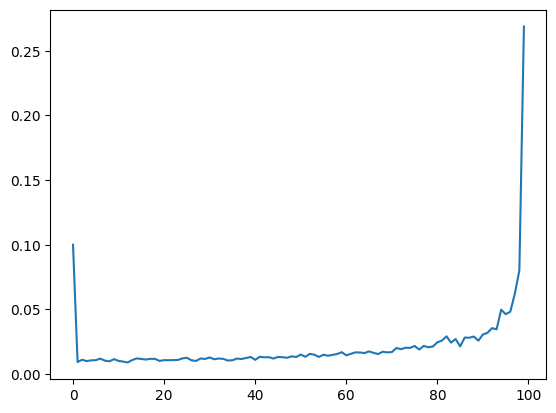

In [46]:
plt.plot(e1_corrs_binned_scatter)

Text(0.5, 1.0, 'e1 autocorrelations')

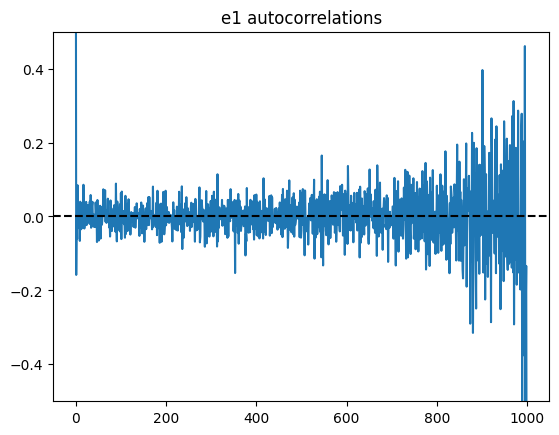

In [30]:
e1_corrs = autocorrelation(e1, axis=0)
plt.plot(e1_corrs[:,0])
# plt.plot(e1_corrs[:,1])
# plt.plot(e1_corrs[:,2])
plt.axhline(0.0, color='k', linestyle='--')
plt.ylim(-0.5, 0.5)
plt.title('e1 autocorrelations')

Text(0.5, 1.0, 'e2 autocorrelations')

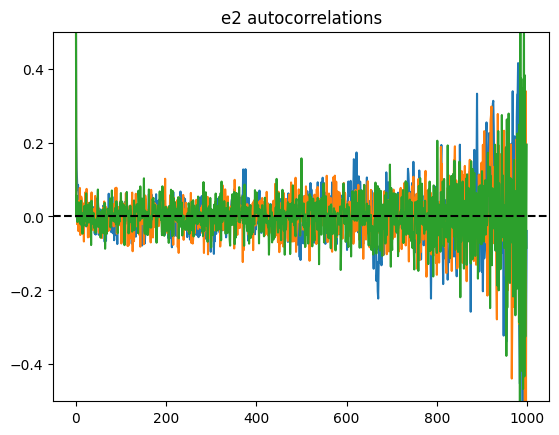

In [105]:
e2_corrs = autocorrelation(e2, axis=1)
plt.plot(e2_corrs[0])
plt.plot(e2_corrs[1])
plt.plot(e2_corrs[2])
plt.axhline(0.0, color='k', linestyle='--')
plt.ylim(-0.5, 0.5)
plt.title('e2 autocorrelations')

In [106]:
# t1 = tfp.mcmc.effective_sample_size(e1.T, filter_beyond_positive_pairs=False).numpy()
# t2 = tfp.mcmc.effective_sample_size(e2.T).numpy()
# t1, t2

In [75]:
# t1.mean(), t2.mean()

(845.31396, 975.0319)

In [112]:
t1 = tfp.mcmc.effective_sample_size(e1.T, filter_beyond_positive_pairs=True).numpy()
t2 = tfp.mcmc.effective_sample_size(e2.T, filter_beyond_positive_pairs=True).numpy()
t1, t2

(array([630.88446, 650.80994, 817.9474 , 301.12573, 690.55396, 310.3932 ,
        371.65775, 597.1338 , 543.0666 , 667.58655], dtype=float32),
 array([398.12717, 921.7669 , 921.1327 , 715.5509 , 515.54846, 657.257  ,
        373.47043, 594.4974 , 856.16144, 428.17957], dtype=float32))

In [113]:
t1.sum()

5581.159

## Run multiple noise realizations